In [ ]:
from google.colab  import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Sun Aug 15 00:36:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import gc
gc.collect()

109

In [ ]:
# !cp -r /content/drive/MyDrive/SETI/new/seti_2layer1.zip ./
# !unzip /content/seti_2layer1.zip
# !rm /content/seti_2layer1.zip
# gc.collect()
# !cp -r /content/drive/MyDrive/SETI/new/seti_2layer2.zip ./
# !unzip /content/seti_2layer2.zip
# !rm /content/seti_2layer2.zip

In [ ]:
# !mv /content/content/train2/*  /content/content/
# !rm -r /content/content/train2/
# !mv /content/content/train3/*  /content/content/
# !rm -r /content/content/train3/

In [ ]:
# !cp -r /content/drive/MyDrive/SETI/new/train_labels.csv.zip "/content"
# !cp -r /content/drive/MyDrive/SETI/new/sample_submission.csv "/content"

In [ ]:
# !unzip /content/train_labels.csv.zip
# !rm /content/train_labels.csv.zip

In [ ]:
!mv ./content ./train

mv: cannot stat './content': No such file or directory


# Prapere

## Install

In [ ]:
%%bash
pip install pytorch-pfn-extras
pip install timm==0.4.12

## Import

In [ ]:
!pip install albumentations==0.4.6
import albumentations 
from albumentations.pytorch import ToTensorV2
!pip install adamp
from adamp import AdamP

In [ ]:
import os
import gc
import copy 
import yaml
import random
import shutil
import typing as tp
import cv2
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.cuda import amp

import timm

import albumentations as A
# from albumentations.pytorch import ToTensorV2

import pytorch_pfn_extras as ppe
from pytorch_pfn_extras.config import Config
from pytorch_pfn_extras.training import extensions as ppe_exts, triggers as ppe_triggers

In [ ]:
ROOT = Path.cwd().parent
INPUT = ROOT / "content"
OUTPUT = ROOT / "output"
# DATA = INPUT / "seti-breakthrough-listen"
DATA = INPUT / ""
TRAIN = DATA / "train"
TEST = DATA / "test"

TMP = ROOT / "tmp"
TMP.mkdir(exist_ok=True)

RANDOM_SEED = 1086
CLASSES = ["target",]
N_CLASSES = len(CLASSES)

#FOLDS = [0, 1, 2, 3, 4]
#N_FOLDS = len(FOLDS)

FOLDS = [0]
N_FOLDS = 5

## Read Data, Split folds

In [ ]:
train = pd.read_csv(DATA / "train_labels.csv")
smpl_sub = pd.read_csv(DATA / "sample_submission.csv")

In [ ]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)
train["fold"] = -1
for fold_id, (_, val_idx) in enumerate(skf.split(train["id"], train["target"])):
    train.loc[val_idx, "fold"] = fold_id

In [ ]:
train.groupby("fold").agg(total=("id", len), pos=("target", sum))

,total,pos
fold,,
0,12000,1200
1,12000,1200
2,12000,1200
3,12000,1200
4,12000,1200


## Definition of Model, Dataset, Metric

In [ ]:
def get_activation(activ_name: str="relu"):
    """"""
    act_dict = {
        "relu": nn.ReLU(inplace=True),
        "tanh": nn.Tanh(),
        "sigmoid": nn.Sigmoid(),
        "identity": nn.Identity()}
    if activ_name in act_dict:
        return act_dict[activ_name]
    else:
        raise NotImplementedError
        

class Conv2dBNActiv(nn.Module):
    """Conv2d -> (BN ->) -> Activation"""
    
    def __int__(
        self, in_channels: int, out_channels: int,
        kernel_size: int, stride: int=1, padding: int=0,
        bias: bool=False, use_bn: bool=True, activ: str="relu"
    ):
        """"""
        super(Conv2dBNActiv, self).__init__()
        layers = []
        layers.append(nn.Conv2d(
            in_channels, out_channels,
            kernel_size, stride, padding, bias=bias))
        if use_bn:
            layers.append(nn.BatchNorm2d(out_channels))
            # layers.append(GroupNorm2d(out_channels))              #Group normalisation
            
        layers.append(get_activation(activ))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        """Forward"""
        return self.layers(x)
        

class SSEBlock(nn.Module):
    """channel `S`queeze and `s`patial `E`xcitation Block."""

    def __init__(self, in_channels: int):
        """Initialize."""
        super(SSEBlock, self).__init__()
        self.channel_squeeze = nn.Conv1d(
            in_channels=in_channels, out_channels=1,
            kernel_size=1, stride=1, padding=0, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """Forward."""
        # # x: (bs, ch, h, w) => h: (bs, 1, h, w)
        h = self.sigmoid(x)
        # # x, h => return: (bs, ch, h, w)
        return x * h
    
    
sigmoid = torch.nn.Sigmoid()


class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        # i = ctx.saved_variables[0]
        i = ctx.saved_tensors[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class Swish_Module(torch.nn.Module):
    def forward(self, x):
        return Swish.apply(x)

class eca_layer(nn.Module):
    """Constructs a ECA module.
    Args:
        channel: Number of channels of the input feature map
        k_size: Adaptive selection of kernel size
    """
    def __init__(self, channel, k_size=3):
        super(eca_layer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # feature descriptor on the global spatial information
        y = self.avg_pool(x)

        # # Two different branches of ECA module
        # y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)

        # Multi-scale information fusion
        y = self.sigmoid(y)

        return x * y.expand_as(x)


def random_power(images, power = 1.5, c= 0.7):
    images = images - images.min()
    images = images/(images.max()+0.0000001)
    images = images**(random.random()*power + c)
    return images

### Model

In [ ]:
class BasicImageModel(nn.Module):
    
    def __init__(
        self, base_name: str, dims_head: tp.List[int],
        pretrained=False, in_channels: int=3
    ):
        """Initialize"""
        self.base_name = base_name
        super(BasicImageModel, self).__init__()
        self.activation = Swish_Module()
        
        # # prepare backbone
        if hasattr(timm.models, base_name):
            base_model = timm.create_model(
                base_name, num_classes=0, pretrained=pretrained, in_chans=in_channels)
            in_features = base_model.num_features
            print("load imagenet pretrained:", pretrained)
        else:
            raise NotImplementedError

        self.backbone = base_model
        print(f"{base_name}: {in_features}")
        
        # # prepare head clasifier
        if dims_head[0] is None:
            dims_head[0] = in_features

        # layers_list = []
        # for i in range(len(dims_head) - 2):
        #     in_dim, out_dim = dims_head[i: i + 2]
        #     layers_list.extend([
        #         nn.Linear(in_dim, out_dim),
        #         nn.ReLU(), nn.Dropout(0.5),])
        # layers_list.append(
        #     nn.Linear(dims_head[-2], dims_head[-1]))
        # self.head_cls = nn.Sequential(*layers_list)

        # for i in range(len(dims_head) - 2):
        #     in_dim, out_dim = dims_head[i: i + 2]


        self.head_cls = nn.Sequential(
            # SpatialAttentionBlock(in_features, [64, 32, 16, 1]),
            # eca_layer(1,3),
            # nn.AdaptiveAvgPool1d(output_size=1),
            # nn.Flatten(start_dim=1),
              nn.Linear(in_features, in_features),
              self.activation,
              nn.ReLU(inplace=True),
              nn.Dropout(0.5),
              nn.Linear(in_features, 1))
        
        # layers_list = []
        # for i in range(len(dims_head) - 2):
        #     in_dim, out_dim = dims_head[i: i + 2]
        #     layers_list.extend([
        #         nn.Linear(in_dim, out_dim),
        #         nn.ReLU(), nn.Dropout(0.5),])
        # layers_list.append(
        #         SpatialAttentionBlock(in_features, [64, 32, 16, 1]),
        #         nn.AdaptiveAvgPool2d(output_size=1),
        #         nn.Flatten(start_dim=1),
        #         nn.Linear(dims_head[-2], dims_head[-1]))
        # self.head_cls = nn.Sequential(*layers_list)

    def forward(self, x):
        """Forward"""
        h = self.backbone(x)
        h = self.head_cls(h)
        return h

# Hide

In [ ]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
def show_cleaned_image_individually(image):
    image_on = None
    image_off = None
    clean_image = None
    
    for i in range(0,6,2):
        temp_on = image[i]
        temp_off = image[i+1]
        
        temp_on = temp_on + 50
        temp_off = temp_off + 50
        
        model = NMF(init = 'random',
                    n_components = 2,
                    solver = 'mu',
                    alpha = 0.01,
                    random_state = 0,
                   )
        
        W_on = model.fit_transform(temp_on)
        H_on = model.components_

        W_off = model.fit_transform(temp_off)
        H_off = model.components_
        
        temp_clean = normalize(temp_on - np.matmul(W_on, H_off))
        
        if image_off is None:
            image_off = image[i+1]
        else:
            image_off = np.concatenate((image_off, image[i+1]))

        if image_on is None:
            image_on = image[i]
        else:
            image_on = np.concatenate((image_on, image[i]))
            
        if clean_image is None:
            clean_image = temp_clean
        else:
            clean_image = np.concatenate((clean_image, temp_clean))

    return clean_image

# Dataset

In [ ]:
FilePath = tp.Union[str, Path]
Label = tp.Union[int, float, np.ndarray]

class SetiSimpleDataset(torch.utils.data.Dataset):
    """
    Dataset using 6 channels by stacking them along time-axis

    Attributes
    ----------
    paths : tp.Sequence[FilePath]
        Sequence of path to cadence snippet file
    labels : tp.Sequence[Label]
        Sequence of label for cadence snippet file
    transform: albumentations.Compose
        composed data augmentations for data
    """

    def __init__(
        self,
        paths: tp.Sequence[FilePath],
        labels: tp.Sequence[Label],
        transform: A.Compose,
    ):
        """Initialize"""
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        """Return num of cadence snippets"""
        return len(self.paths)

    def __getitem__(self, index: int):
        """Return transformed image and label for given index."""
        path, label = self.paths[index], self.labels[index]
        img = self._read_cadence_array(path)
        img = self.transform(image=img)["image"]
        return {"image": img, "target": label}

    def _read_cadence_array(self, path: Path):
        """Read cadence file and reshape"""
        img = np.load(path)  # shape: (6, 273, 256)
        img = np.vstack(img)  # shape: (1638, 256)
        img = img.transpose(1, 0)  # shape: (256, 1638)
        img = img.astype("f")[..., np.newaxis]  # shape: (256, 1638, 1)
        return img

    def lazy_init(self, paths=None, labels=None, transform=None):
        """Reset Members"""
        if paths is not None:
            self.paths = paths
        if labels is not None:
            self.labels = labels
        if transform is not None:
            self.transform = transform

class SetiAObsDataset(SetiSimpleDataset):
    """Use only on-target observation"""

    def _read_cadence_array(self, path: Path):
        """Read cadence file and reshape"""
        img = np.load(path)

        
        # img = np.load(path)[[0, 2, 4]]  # shape: (3, 273, 256)
        # # flip = (np.flip(img,1))
        # img = np.vstack(img)     # shape: (819, 256)
        # # flip = np.vstack(flip)
        # # img = np.hstack((img,flip))
        # img = img.transpose(1, 0)       # shape: (256, 819)  
        # # img = (img - np.min(img))/np.ptp(img)
        # # Clip    
        # # img   = ((np.clip(img, -1, 3) + 1) / 4 * 255).astype(np.uint8)
        # img   = ((np.clip(img, -3, 3) + 3) / 6 * 255).astype(np.uint8)
        
        
        # img2 = np.load(path)[[1, 3, 5]]  # shape: (3, 273, 256)
        # # flip2 = (np.flip(img2,1))
        # img2 = np.vstack(img2)     # shape: (819, 256)
        # # flip2 = np.vstack(flip2)
        # # img2 = np.hstack((img2,flip2))
        # img2 = img2.transpose(1, 0)  # shape: (256, 819)  
        # # img2 = (img - np.min(img))/np.ptp(img)
        # # Clip 
        # img2   = ((np.clip(img2, -3, 3) + 3) / 6 * 255).astype(np.uint8)

        # # img3 = np.load(path)[[0,1,2,3,4,5]] 
        # # img3 = np.vstack(img3)
        # # img3 = img3.transpose(1,0)
        # # img3 = ((np.clip(img3, -1, 3) + 1) / 4 * 255).astype(np.uint8)

        #ch1 = img[:,:,0]
        #ch2 = img[:,:,1]
        #ch3 = ch1 - ch2
        #img3 = ((np.clip(img3, min, max) -min) /(max - min) * 255).astype(np.uint8)
        # img = np.stack([ch1, ch2, ch3], axis = 2)
        img = img.astype("f")
        return img

### Metric

In [ ]:
Batch = tp.Union[tp.Tuple[torch.Tensor], tp.Dict[str, torch.Tensor]]
ModelOut = tp.Union[tp.Tuple[torch.Tensor], tp.Dict[str, torch.Tensor], torch.Tensor]


class ROCAUC(nn.Module):
    """ROC AUC score"""

    def __init__(self, average="macro") -> None:
        """Initialize."""
        self.average = average
        super(ROCAUC, self).__init__()

    def forward(self, y, t) -> float:
        """Forward."""
        if isinstance(y, torch.Tensor):
            y = y.detach().cpu().numpy()
        if isinstance(t, torch.Tensor):
            t = t.detach().cpu().numpy()

        return roc_auc_score(t, y, average=self.average)


def micro_average(
    metric_func: nn.Module,
    report_name: str, prefix="val",
    pred_index: int=-1, label_index: int=-1,
    pred_key: str="logit", label_key: str="target",
) -> tp.Callable:
    """Return Metric Wrapper for Simple Mean Metric"""
    metric_sum = [0.]
    n_examples = [0]
    
    def wrapper(batch: Batch, model_output: ModelOut, is_last_batch: bool):
        """Wrapping metric function for evaluation"""
        if isinstance(batch, tuple): 
            t = batch[label_index]
        elif isinstance(batch, dict):
            t = batch[label_key]
        else:
            raise NotImplementedError

        if isinstance(model_output, tuple):
            y = model_output[pred_index]
        elif isinstance(model_output, dict):
            y = model_output[pred_key]
        else:
            y = model_output

        metric = metric_func(y, t).item()
        metric_sum[0] += metric * y.shape[0]
        n_examples[0] += y.shape[0]

        if is_last_batch:
            final_metric = metric_sum[0] / n_examples[0]
            ppe.reporting.report({f"{prefix}/{report_name}": final_metric})
            # # reset state
            metric_sum[0] = 0.
            n_examples[0] = 0

    return wrapper


def calc_across_all_batchs(
    metric_func: nn.Module,
    report_name: str, prefix="val",
    pred_index: int=-1, label_index: int=-1,
    pred_key: str="logit", label_key: str="target",
) -> tp.Callable:
    """
    Return Metric Wrapper for Metrics caluculated on all data
    
    storing predictions and labels of evry batch, finally calculating metric on them.
    """
    pred_list = []
    label_list = []
    
    def wrapper(batch: Batch, model_output: ModelOut, is_last_batch: bool):
        """Wrapping metric function for evaluation"""
        if isinstance(batch, tuple):
            t = batch[label_index]
        elif isinstance(batch, dict):
            t = batch[label_key]
        else:
            raise NotImplementedError

        if isinstance(model_output, tuple):
            y = model_output[pred_index]
        elif isinstance(model_output, dict):
            y = model_output[pred_key]
        else:
            y = model_output

        pred_list.append(y.numpy())
        label_list.append(t.numpy())

        if is_last_batch:
            pred = np.concatenate(pred_list, axis=0)
            label = np.concatenate(label_list, axis=0)
            final_metric = metric_func(pred, label)
            ppe.reporting.report({f"{prefix}/{report_name}": final_metric})
            # # reset state
            pred_list[:] = []
            label_list[:] = []

    return wrapper

# Train

## config_types for evaluating configuration

I use [pytorch-pfn-extras](https://github.com/pfnet/pytorch-pfn-extras) for training NNs. This library has useful config systems but requires some preparation.

For more details, see [docs](https://github.com/pfnet/pytorch-pfn-extras/blob/master/docs/config.md).

In [ ]:
CONFIG_TYPES = {
    # # utils
    "__len__": lambda obj: len(obj),
    "method_call": lambda obj, method: getattr(obj, method)(),

    # # Dataset, DataLoader
    "SetiSimpleDataset": SetiSimpleDataset,
    "SetiAObsDataset": SetiAObsDataset,
    "DataLoader": torch.utils.data.DataLoader,

    # # Data Augmentation
    "Compose": A.Compose, "OneOf": A.OneOf,
    "Resize": A.Resize,
    "HorizontalFlip": A.HorizontalFlip, "VerticalFlip": A.VerticalFlip,
    # "ShiftScaleRotate": A.ShiftScaleRotate,
    # "IAAAffine": A.IAAAffine, 
    # "RandomResizedCrop": A.RandomResizedCrop,
    "Cutout": A.Cutout,
    # "Normalize": A.Normalize,
    "ToTensorV2": ToTensorV2,

    # # Model
    "BasicImageModel": BasicImageModel,

    # # Optimizer
    "AdamW": optim.AdamW,
    # "Adam": optim.Adam,
    # "AdamP": AdamP,

    # # Scheduler
    "OneCycleLR": lr_scheduler.OneCycleLR,

    # # Loss,Metric
    "BCEWithLogitsLoss": nn.BCEWithLogitsLoss,
    "ROCAUC": ROCAUC,

    # # Metric Wrapper
    "micro_average": micro_average,
    "calc_across_all_batchs": calc_across_all_batchs,

    # # PPE Extensions
    "ExtensionsManager": ppe.training.ExtensionsManager,

    "observe_lr": ppe_exts.observe_lr,
    "LogReport": ppe_exts.LogReport,
    "PlotReport": ppe_exts.PlotReport,
    "PrintReport": ppe_exts.PrintReport,
    "PrintReportNotebook": ppe_exts.PrintReportNotebook,
    "ProgressBar": ppe_exts.ProgressBar,
    "ProgressBarNotebook": ppe_exts.ProgressBarNotebook,
    "snapshot": ppe_exts.snapshot,
    "LRScheduler": ppe_exts.LRScheduler, 

    "MinValueTrigger": ppe_triggers.MinValueTrigger,
    "MaxValueTrigger": ppe_triggers.MaxValueTrigger,
    "EarlyStoppingTrigger": ppe_triggers.EarlyStoppingTrigger,
}

## configration

In [ ]:
timm.list_models()

['adv_inception_v3',
 'bat_resnext26ts',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspdarknet53_iabn',
 'cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'cspresnext50',
 'cspresnext50_iabn',
 'darknet53',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet121d',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenet264',
 'densenet264d_iabn',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2n

In [ ]:
pre_eval_cfg = yaml.safe_load(
"""
globals:
  seed: 1086
  val_fold: null  # indicate when training
  output_path: null # indicate when training
  device: cuda
  enable_amp: False
  max_epoch: 20

model:
  type: BasicImageModel 
  dims_head: [null, 1]
  base_name: resnet34d
  # base_name: tf_efficientnet_b0
  # base_name: efficientnet_b0  
  # base_name: tf_efficientnetv2_b0 
  # base_name: tf_efficientnet_b0_ns
  # base_name: resnet50d
  pretrained: True
  # in_channels: 1
  in_channels: 2
  # in_channels: 3

dataset:
  height: 640
  width: 640
  mixup: {enabled: True, alpha: 0.4}  #1.0 == 0.87
  train:
    type: SetiAObsDataset
    paths: null  # set by lazy_init
    labels: null  # set by lazy_init
    transform:
      type: Compose
      transforms:
        - {type: Resize, p: 1.0, height: "@/dataset/height", width: "@/dataset/width"}
        - {type: HorizontalFlip, p: 0.5}
        - {type: VerticalFlip, p: 0.5}
        # - {type: ShiftScaleRotate, p: 0.5, shift_limit: 0.2, scale_limit: 0.2,
        #     rotate_limit: 20, border_mode: 0, value: 0, mask_value: 0}
        # - {type: IAAAffine, p: 0.5, scale: 1.0}
        # - {type: RandomResizedCrop, p: 1.0,
            # scale: [0.9, 1.0], height: "@/dataset/height", width: "@/dataset/width"}
        # - {type: Normalize, mean: 0.4887381077884414, std: 0.23064819430546407, max_pixel_value: 255.0, p: 1.0}
        - {type: ToTensorV2, always_apply: True}
  val:
    type: SetiAObsDataset
    paths: null  # set by lazy_init
    labels: null  # set by lazy_init
    transform:
      type: Compose
      transforms:
        - {type: Resize, p: 1.0, height: "@/dataset/height", width: "@/dataset/width"}
        # - {type: Normalize, mean: 0.4887381077884414, std: 0.23064819430546407, max_pixel_value: 255.0, p: 1.0}
        - {type: ToTensorV2, always_apply: True}  
  test:
    type: SetiAObsDataset
    paths: null  # set by lazy_init 
    labels: null  # set by lazy_init
    transform: "@/dataset/val/transform"

loader:
  train: {type: DataLoader, dataset: "@/dataset/train",
    batch_size: 16, num_workers: 2, shuffle: True, pin_memory: True, drop_last: True}
  val: {type: DataLoader, dataset: "@/dataset/val",
    batch_size: 16, num_workers: 2, shuffle: False, pin_memory: True, drop_last: False}
  test: {type: DataLoader, dataset: "@/dataset/test",
    batch_size: 16, num_workers: 2, shuffle: False, pin_memory: True, drop_last: False}

optimizer:
  type: AdamW   #Adamw
  # type: Adam
  params: {type: method_call, obj: "@/model", method: parameters}
  # lr: 1.0e-06
  # weight_decay: 1.0e-02
  lr: 1.0e-03
  # type: AdamP
  # params: {type: method_call, obj: "@/model", method: parameters}  
  # lr: 2.5e-04

scheduler:
  type: OneCycleLR
  optimizer: "@/optimizer"
  epochs: "@/globals/max_epoch"
  steps_per_epoch: {type: __len__, obj: "@/loader/train"}
  max_lr: 1.0e-3
  pct_start: 0.1
  anneal_strategy: cos
  div_factor: 1.0e+3
  final_div_factor: 1.0e+3

loss: {type: BCEWithLogitsLoss}

eval:
  - type: micro_average
    metric_func: {type: BCEWithLogitsLoss}
    report_name: loss
  - type: calc_across_all_batchs
    metric_func: {type: ROCAUC}
    report_name: metric

manager:
  type: ExtensionsManager
  models: "@/model"
  optimizers: "@/optimizer"
  max_epochs: "@/globals/max_epoch"
  iters_per_epoch: {type: __len__, obj: "@/loader/train"}
  out_dir: "@/globals/output_path"
  # stop_trgiger: {type: EarlyStoppingTrigger,
  #   monitor: val/metric, mode: max, patience: 5, verbose: True,
  #   check_trigger: [1, epoch], max_trigger: ["@/globals/max_epoch", epoch]}

extensions:
  # # log
  - {type: observe_lr, optimizer: "@/optimizer"}
  - {type: LogReport}
  - {type: PlotReport, y_keys: lr, x_key: epoch, filename: lr.png}
  - {type: PlotReport, y_keys: [train/loss, val/loss], x_key: epoch, filename: loss.png}
  - {type: PlotReport, y_keys: val/metric, x_key: epoch, filename: metric.png}
  - {type: PrintReport, entries: [
      epoch, iteration, lr, train/loss, val/loss, val/metric, elapsed_time]}
  - {type: ProgressBarNotebook, update_interval: 20}
  # snapshot
  - extension: {type: snapshot, target: "@/model", filename: "snapshot_by_metric_epoch_{.epoch}.pth"}
    trigger: {type: MaxValueTrigger, key: "val/metric", trigger: [1, epoch]}
  # # lr scheduler
  - {type: LRScheduler, scheduler: "@/scheduler", trigger: [1,  iteration]}
"""
)

## functions for training

In [ ]:
def set_random_seed(seed: int = 20, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = deterministic  # type: ignore


def to_device(
    tensors: tp.Union[tp.Tuple[torch.Tensor], tp.Dict[str, torch.Tensor]],
    device: torch.device, *args, **kwargs
):
    if isinstance(tensors, tuple):
        return (t.to(device, *args, **kwargs) for t in tensors)
    elif isinstance(tensors, dict):
        return {
            k: t.to(device, *args, **kwargs) for k, t in tensors.items()}
    else:
        return tensors.to(device, *args, **kwargs)

In [ ]:
def get_path_label(cfg: Config, train_all: pd.DataFrame):
    """Get file path and target info."""
    use_fold = cfg["/globals/val_fold"]

    train_df = train_all[train_all["fold"] != use_fold]
    val_df = train_all[train_all["fold"] == use_fold]
    
    train_path_label = {
        "paths": [TRAIN / f"{img_id[0]}/{img_id}.npy" for img_id in train_df["id"].values],
        "labels": train_df[CLASSES].values.astype("f")}
    val_path_label = {
        "paths": [TRAIN / f"{img_id[0]}/{img_id}.npy" for img_id in val_df["id"].values],
        "labels": val_df[CLASSES].values.astype("f")
    }
    return train_path_label, val_path_label


def get_eval_func(cfg, model, device):
    
    def eval_func(**batch):
        """Run evaliation for val or test. This function is applied to each batch."""
        batch = to_device(batch, device)
        x = batch["image"]
        with amp.autocast(cfg["/globals/enable_amp"]): 
            y = model(x)
        return y.detach().cpu().to(torch.float32)  # input of metrics

    return eval_func


def mixup_data(use_mixup, x, t, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if not use_mixup:
        return x, t, None, None
    
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    t_a, t_b = t, t[index]
    return mixed_x, t_a, t_b, lam

def get_criterion(use_mixup, loss_func):

    def mixup_criterion(pred, t_a, t_b, lam):
        return lam * loss_func(pred, t_a) + (1 - lam) * loss_func(pred, t_b)

    def single_criterion(pred, t_a, t_b, lam):
        return loss_func(pred, t_a)
    
    if use_mixup:
        return mixup_criterion
    else:
        return single_criterion

In [ ]:
  def train_one_fold(cfg, train_all):
    """Main"""
    torch.backends.cudnn.benchmark = True
    set_random_seed(cfg["/globals/seed"], True)
    device = torch.device(cfg["/globals/device"])
    
    train_path_label, val_path_label = get_path_label(cfg, train_all)
    print("train: {}, val: {}".format(len(train_path_label["paths"]), len(val_path_label["paths"])))
   
    cfg["/dataset/train"].lazy_init(**train_path_label)
    cfg["/dataset/val"].lazy_init(**val_path_label)
    train_loader = cfg["/loader/train"]
    val_loader = cfg["/loader/val"]

    model = cfg["/model"]
    model.to(device)
    optimizer = cfg["/optimizer"]
    loss_func = cfg["/loss"]
    loss_func.to(device)
    
    manager = cfg["/manager"]
    for ext in cfg["/extensions"]:
        if isinstance(ext, dict):
            manager.extend(**ext)
        else:
            manager.extend(ext)

    evaluator = ppe_exts.Evaluator(
        val_loader, model, eval_func=get_eval_func(cfg, model, device),
        metrics=cfg["/eval"], progress_bar=False)
    manager.extend(evaluator, trigger=(1, "epoch"))

    use_amp = cfg["/globals/enable_amp"]
    scaler = amp.GradScaler(enabled=use_amp)
    use_mixup = cfg["/dataset/mixup/enabled"]
    mixup_alpha = cfg["/dataset/mixup/alpha"]
    
    while not manager.stop_trigger:
        model.train() 
        for batch in train_loader:
            with manager.run_iteration():
                batch = to_device(batch, device)
                x, t = batch["image"], batch["target"]
                # # for mixup
                mixed_x, t_a, t_b, lam = mixup_data(use_mixup, x, t, mixup_alpha)
                criterion = get_criterion(use_mixup, loss_func)
                
                optimizer.zero_grad()
                with amp.autocast(use_amp):
                    y = model(mixed_x)
                    loss = criterion(y, t_a, t_b, lam)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                ppe.reporting.report({'train/loss': loss.item()})

## run train

In [ ]:
pre_eval_cfg_list = []
for fold_id in FOLDS:
    tmp_cfg = copy.deepcopy(pre_eval_cfg)
    tmp_cfg["globals"]["val_fold"] = fold_id
    tmp_cfg["globals"]["output_path"] = str(TMP / f"fold{fold_id}")
    pre_eval_cfg_list.append(tmp_cfg)

In [ ]:
gc.collect()

174

In [ ]:
for pre_eval_cfg in pre_eval_cfg_list:
    cfg = Config(pre_eval_cfg, types=CONFIG_TYPES)
    print(f"\nfold:", cfg["/globals/val_fold"])
    train_one_fold(cfg, train)
    del cfg
    torch.cuda.empty_cache()
    gc.collect()


fold: 0
train: 48000, val: 12000
load imagenet pretrained: True
resnet34d: 512


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch       iteration   lr          train/loss  val/loss    val/metric  elapsed_time
1           3000        0.000500369  0.371782    0.298323    0.653127    828.822       
2           6000        0.001       0.296226    0.264908    0.772837    1663.54       
3           9000        0.000992404  0.270881    0.241482    0.795785    2498.63       
4           12000       0.000969846  0.260457    0.210473    0.834721    3334.16       
5           15000       0.000933013  0.254129    0.203071    0.840254    4170.18       
6           18000       0.000883022  0.250381    0.231479    0.836327    5006.09       
7           21000       0.000821394  0.248231    0.19386     0.845206    5841.17       
8           24000       0.00075     0.242074    0.191441    0.847776    6676.41       
9           27000       0.00067101  0.240595    0.191889    0.849826    7511.07       
10          30000       0.000586825  0.236774    0.192645    0.846993    8346.12       
11          33000       0.000500001  0

In [ ]:
arr = np.load('/content/train/0/0000799a2b2c42d.npy')
arr.shape

(256, 819, 2)

In [ ]:
def get_train_filename_by_id(_id: str) -> str:
    return f"/content/train/{_id[0]}/{_id}.npy"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


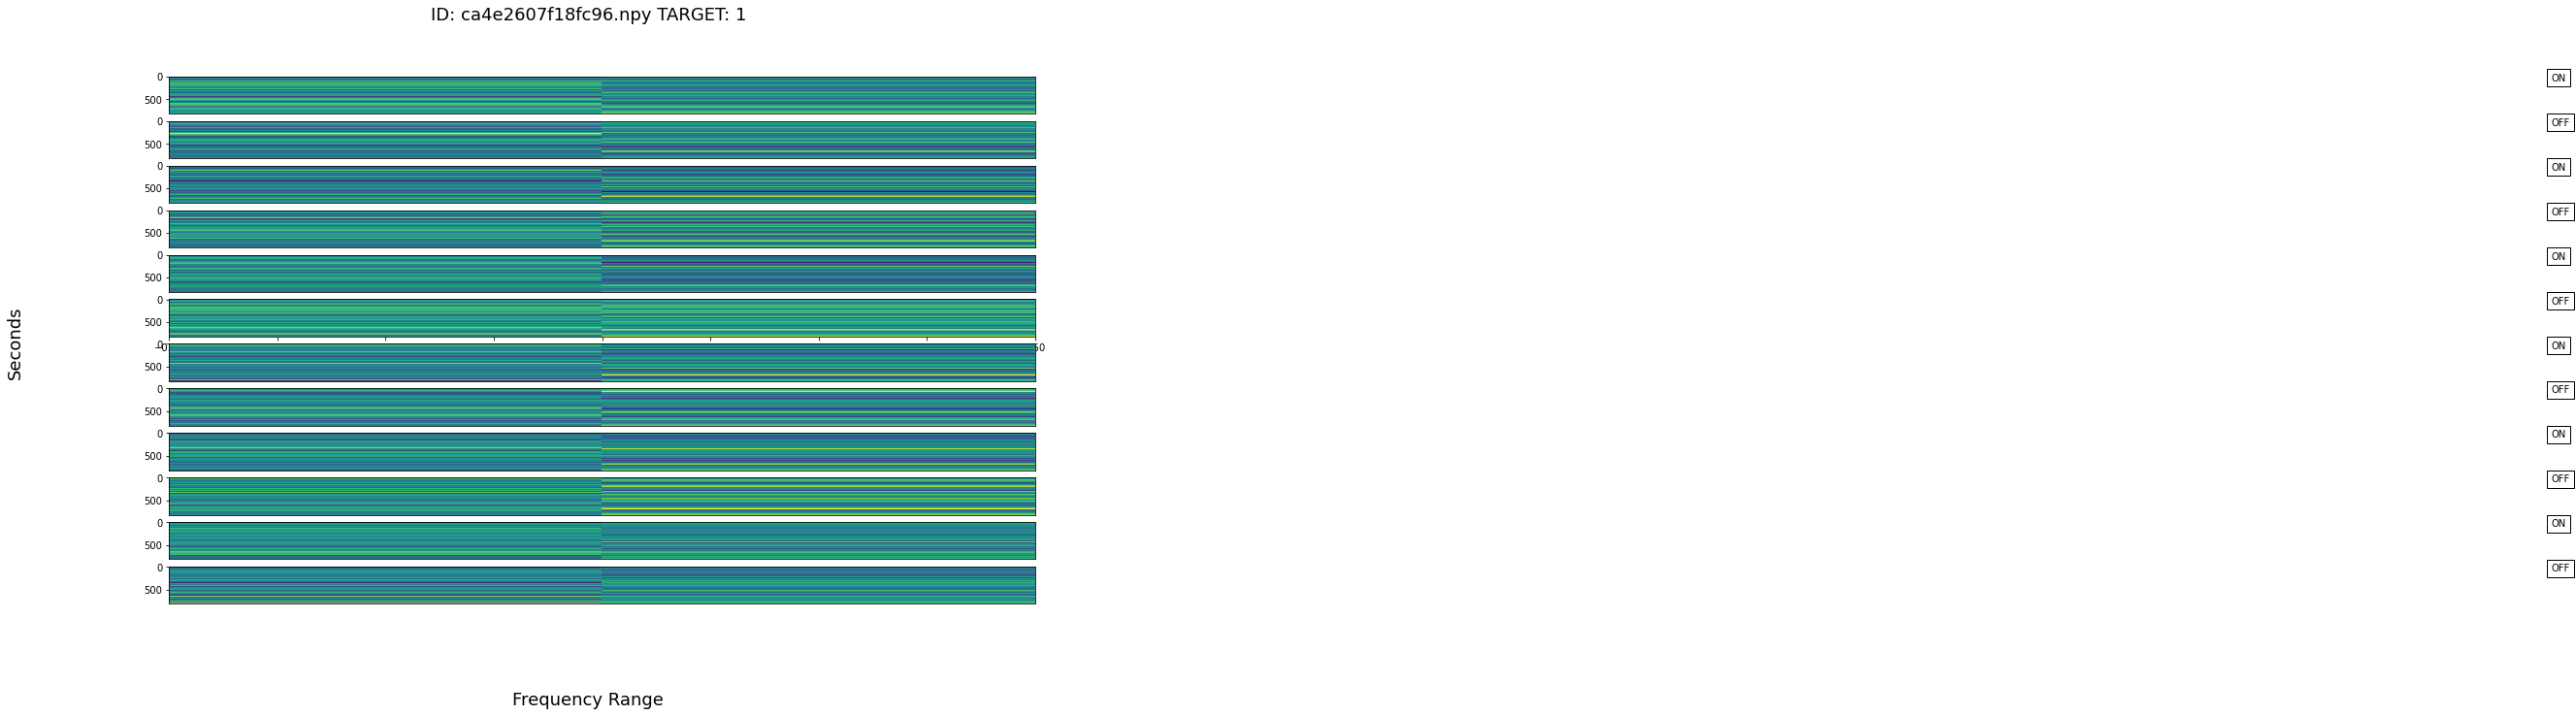

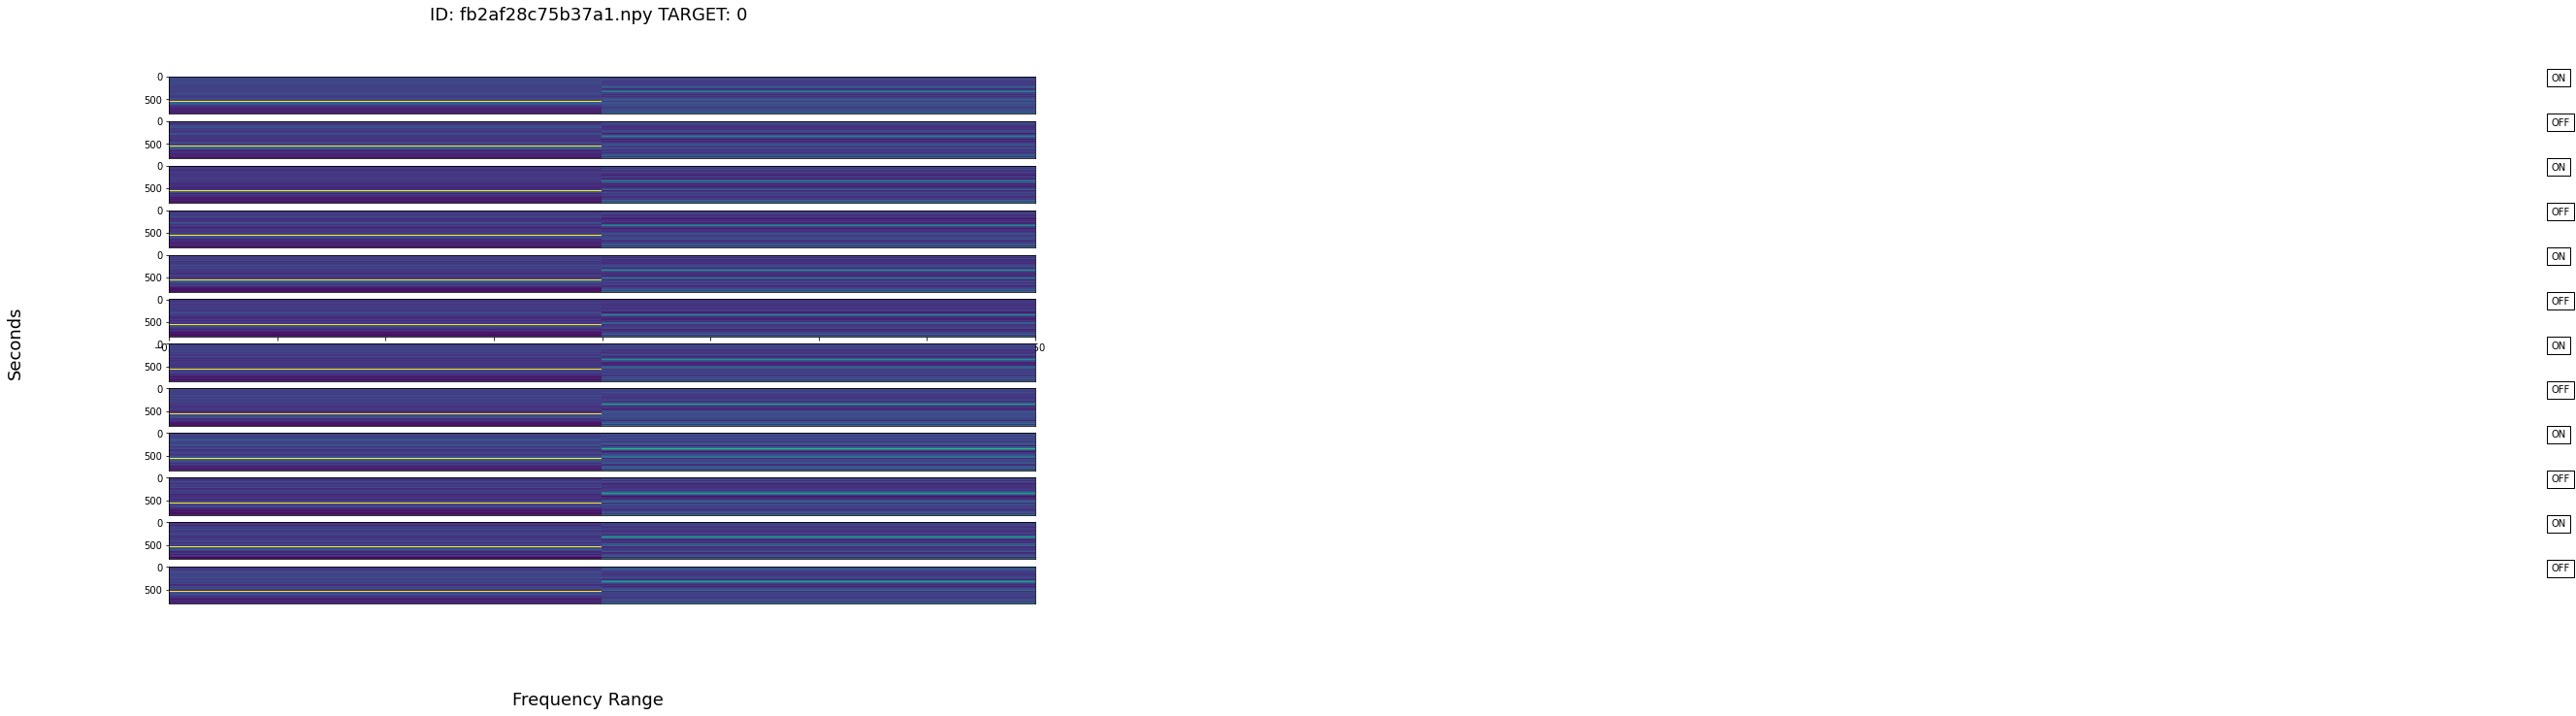

In [ ]:
def show_cadence(filename: str, label: int) -> None:
    fig, axes = plt.subplots(12, 1, figsize = (16, 10))
    ax = axes.ravel()
    arr = np.load(filename)
    
    #arr = _read_cadence_array(arr)
    
    for i in range(12):
        
        ax[i].imshow(arr[i].astype(float), interpolation='nearest', aspect='auto')
        ax[i].text(5, 100, ["ON", "OFF"][i % 2], bbox={'facecolor': 'white'})
        if i != 5:
            ax[i].set_xticks([])
            
    fig.text(0.5, -0.02, 'Frequency Range', ha='center', fontsize=18)
    fig.text(-0.02, 0.5, 'Seconds', va='center', rotation='vertical', fontsize=18)

    plt.suptitle(f"ID: {os.path.basename(filename)} TARGET: {label}", fontsize=18)
    fig.tight_layout()
    plt.show()

positive_target=train.query("target==1").sample().id.item()
negative_target=train.query("target==0").sample().id.item()
show_cadence(get_train_filename_by_id(positive_target), 1)
show_cadence(get_train_filename_by_id(negative_target), 0)

# Inference

## Copy best models

In [ ]:
TMP = ROOT / "tmp"
TMP

PosixPath('/tmp')

In [ ]:
best_log_list = []
for pre_eval_cfg, fold_id in zip(pre_eval_cfg_list, FOLDS):
    exp_dir_path = TMP / f"fold{fold_id}"
    log = pd.read_json(exp_dir_path / "log")
    best_log = log.iloc[[log["val/metric"].idxmax()],]
    best_epoch = best_log.epoch.values[0]
    best_log_list.append(best_log)
    
    best_model_path = exp_dir_path / f"snapshot_by_metric_epoch_{best_epoch}.pth"
    copy_to = f"./best_metric_model_fold{fold_id}.pth"
    shutil.copy(best_model_path, copy_to)
    
    for p in exp_dir_path.glob("*.pth"):
        p.unlink()
    
    shutil.copytree(exp_dir_path, f"./fold{fold_id}")
    
    with open(f"./fold{fold_id}/config.yml", "w") as fw:
        yaml.dump(pre_eval_cfg, fw)
    
pd.concat(best_log_list, axis=0, ignore_index=True)

,train/loss,lr,val/loss,val/metric,epoch,iteration,elapsed_time
0,0.217231,0.000117,0.170729,0.865137,16,48000,13358.967025


In [ ]:
  # import shutil

  # shutil.rmtree('fold0')

## Inference OOF & Test

In [ ]:
def run_inference_loop(cfg, model, loader, device):
    model.to(device)
    model.eval()
    pred_list = []
    with torch.no_grad():
        for batch in tqdm(loader):
            x = to_device(batch["image"], device)
            y = model(x)
            pred_list.append(y.sigmoid().detach().cpu().numpy())
        
    pred_arr = np.concatenate(pred_list)
    del pred_list
    return pred_arr

# --------------

In [ ]:
label_arr = train[CLASSES].values
oof_pred_arr = np.zeros((len(train), N_CLASSES))

fold_id = 0
print(f"[fold {fold_id}]")
tmp_dir = Path(f"./fold{fold_id}")
with open(tmp_dir / "config.yml", "r") as fr:
    cfg = Config(yaml.safe_load(fr), types=CONFIG_TYPES)
device = torch.device(cfg["/globals/device"])
val_idx = train.query("fold == @fold_id").index.values

# # get_dataloader
_, val_path_label = get_path_label(cfg, train)
cfg["/dataset/val"].lazy_init(**val_path_label)
#cfg["/dataset/test"].lazy_init(**test_path_label)
val_loader = cfg["/loader/val"]
#test_loader = cfg["/loader/test"]
model_path = f"./best_metric_model_fold{fold_id}.pth"
model = cfg["/model"]
model.load_state_dict(torch.load(model_path, map_location=device))

val_pred = run_inference_loop(cfg, model, val_loader, device)
val_score = roc_auc_score(label_arr[val_idx], val_pred)

oof_pred_arr[val_idx] = val_pred
# score_list.append([fold_id, val_score])

# test_pred_arr[fold_id] = run_inference_loop(cfg, model, test_loader, device)

#del cfg, val_idx, val_path_label
# del model, val_loader, test_loader
torch.cuda.empty_cache()
gc.collect()

print(f"val score: {val_score:.4f}")

[fold 0]
load imagenet pretrained: True
resnet34d: 512


  0%|          | 0/750 [00:00<?, ?it/s]

val score: 0.8651


In [ ]:
!cp /content/best_metric_model_fold0.pth /content/drive/MyDrive/SETI/two_resnet34d/
!cp /content/fold0/config.yml /content/drive/MyDrive/SETI/two_resnet34d/two_resnet34d_fold0.yml

In [ ]:
#q = np.concatenate([label_arr[val_idx], val_pred], axis = 1)
q[:60]

NameError: ignored

# -----------------

In [ ]:
!cp /content/drive/MyDrive/SETI/new/seti_testprocess.zip ./
!unzip ./seti_testprocess.zip
!rm ./seti_testprocess.zip

In [ ]:
!mv /content/content/test2/*  /content/content/
!rm -r /content/content/test2/
!mv /content/content /content/test

In [ ]:
label_arr = train[CLASSES].values
oof_pred_arr = np.zeros((len(train), N_CLASSES))
score_list = []
test_pred_arr = np.zeros((N_FOLDS, len(smpl_sub), N_CLASSES))
test_path_label = {
    "paths": [DATA / f"test/{img_id[0]}/{img_id}.npy" for img_id in smpl_sub["id"].values],
    "labels": smpl_sub[CLASSES].values.astype("f")
}

for fold_id in range(N_FOLDS):
    print(f"\n[fold {fold_id}]")
    tmp_dir = Path(f"./eff_{fold_id}_config.yml")
    with open(tmp_dir, "r") as fr:
#     with open("../input/seti-test9/config.yml", "r") as fr: 
        cfg = Config(yaml.safe_load(fr), types=CONFIG_TYPES)
    device = torch.device(cfg["/globals/device"])
    val_idx = train.query("fold == @fold_id").index.values

    # # get_dataloader
    _, val_path_label = get_path_label(cfg, train)
    cfg["/dataset/val"].lazy_init(**val_path_label)
    cfg["/dataset/test"].lazy_init(**test_path_label)
    val_loader = cfg["/loader/val"]
    test_loader = cfg["/loader/test"]
    
    # # get model
#     model_path = f"./best_metric_model_fold{fold_id}.pth"
    model_path = f"/content/drive/MyDrive/SETI/effnet_noflip/best_metric_model_fold{fold_id}.pth"
    
    model = cfg["/model"]
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # # inference
    val_pred = run_inference_loop(cfg, model, val_loader, device)
    val_score = roc_auc_score(label_arr[val_idx], val_pred)
    oof_pred_arr[val_idx] = val_pred
    score_list.append([fold_id, val_score])
    
    test_pred_arr[fold_id] = run_inference_loop(cfg, model, test_loader, device)
    
    del cfg, val_idx, val_path_label
    del model, val_loader, test_loader
    torch.cuda.empty_cache()
    gc.collect()
    
    print(f"val score: {val_score:.4f}")

In [ ]:
oof_score = roc_auc_score(label_arr, oof_pred_arr)
score_list.append(["oof", oof_score])
pd.DataFrame(score_list, columns=["fold", "metric"])

In [ ]:
oof_df = train.copy()
oof_df[CLASSES] = oof_pred_arr
oof_df.to_csv("./oof_prediction.csv", index=False)

## Make submission

In [ ]:
sub_df = smpl_sub.copy()
sub_df[CLASSES] = test_pred_arr.mean(axis=0)
sub_df.to_csv("./submission.csv", index=False)

In [ ]:
sub_df.head()

In [ ]:
import pandas as pd
import numpy as np
pred_ns = pd.read_csv('/content/drive/MyDrive/SETI/eff_ns/single_eff_ns.csv')
pred_eff = pd.read_csv('/content/drive/MyDrive/SETI/effnet/eff.csv')
pred_resnet = pd.read_csv('/content/drive/MyDrive/SETI/resnet/resnet_submission.csv')
pred_noflip = pd.read_csv('/content/drive/MyDrive/SETI/effnet_noflip/no_flip.csv')
pred_noisy = pd.read_csv('/content/drive/MyDrive/SETI/two_eff_ns/two_ns.csv')
# pred_tawara = pd.read_csv('/content/drive/MyDrive/SETI/tawara_resnet18d.csv')

In [ ]:
oof_ns = pd.read_csv('/content/drive/MyDrive/SETI/eff_ns/oof_eff_ns.csv')
oof_resnet = pd.read_csv('/content/drive/MyDrive/SETI/resnet/oof_resnet.csv')
oof_eff = pd.read_csv('/content/drive/MyDrive/SETI/effnet/oof_eff.csv')
oof_noflip = pd.read_csv('/content/drive/MyDrive/SETI/effnet_noflip/oof_no_flip.csv')
oof_tawara = pd.read_csv('/content/drive/MyDrive/SETI/tawara_resnet18d.csv')

In [ ]:

# t = oof_resnet.copy()
# t['target'] = (0.4*t['target']) + (0.4*oof_ns['target']) + (0.2*oof_eff['target'])

# en = roc_auc_score(label_arr, t['target'])
# print(en)

In [ ]:

t = oof_resnet.copy()
t['target'] = (0.4*t['target']) + (0.35*oof_ns['target']) + (0.15*oof_eff['target']) + (0.1*oof_noflip['target'])

en = roc_auc_score(label_arr, t['target'])
print(en)

In [ ]:
tmp = pred_resnet.copy()
tmp['target'] = 0.2*((0.4*tmp['target']) + (0.35*pred_ns['target']) + (0.15*pred_eff['target']) + (0.1*pred_noflip['target'])) + (0.8*pred_noisy['target'])


In [ ]:
tmp.to_csv('./ensemble_two_one_channel', index = False)

In [ ]:
tmp

# EOF